In [2]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.impute import KNNImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings("ignore")

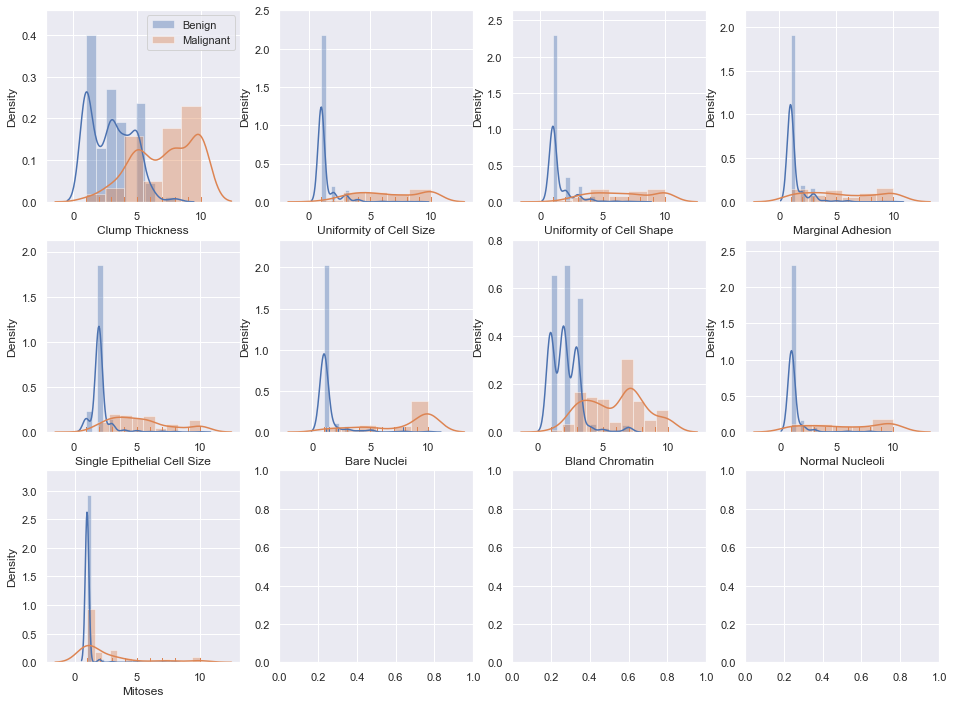

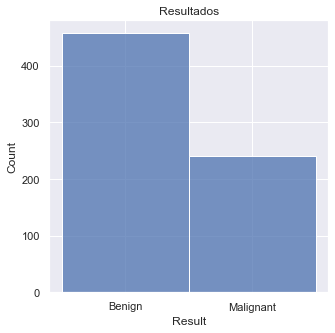

In [4]:
data = pd.read_csv('breast-cancer-wisconsin.csv', sep=",")

data = data.dropna()
#print(data.columns)
data.columns = [
    "ID",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Result"
]

data = data.drop("ID", axis=1)

data = data.replace(['?'], np.nan)

imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)

"""data.loc[data['Result'] == "Benign", 'Result'] = 2
data.loc[data['Result'] == "Malignant", 'Result'] = 4
"""
data.loc[data['Result'] == 2, 'Result'] = "Benign"
data.loc[data['Result'] == 4, 'Result'] = "Malignant"

fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=4)

for i, column in enumerate(data.columns[:-1]):
    for result in ["Benign", "Malignant"]:
      target = data.loc[data['Result'] == result]
      sns.distplot(target[column], rug=True, kde=True, ax=axes[i//4,i%4], label=result)
      if i==0:
        axes[0,0].legend()
        
"""data.loc[data['Result'] == "Benign", 'Result'] = 2
data.loc[data['Result'] == "Malignant", 'Result'] = 4"""

fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["Result"], palette="Blues_d",ax=ax, label=["Benign", "Malignant"])
ax.set_title('Resultados')
plt.show()

In [1]:
from sklearn.model_selection import train_test_split

predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["Result"]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

#alphas = np.linspace(0, 1, 10)
alphas = np.linspace(1, 100000)

for a in alphas:
    perceptron = Perceptron(tol=None)
    perceptron.fit(X_train, y_train)

    train_acc = perceptron.score(X_train_vals, y_train_vals)
    val_acc = perceptron.score(X_val_vals, y_val_vals)
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
    print("\nTrain/Val/Test Accuracy Binaria (via Perceptron)\n")
    print(train_acc,val_acc,test_acc)

NameError: name 'data' is not defined

### Referencias
#### Binaries

* No Dataset breast-cancer-wisconsin
Dataset iris 